**1. Generalized autoregressive conditional heteroskedasticity (GARCH)**

GARCH describes an approach to estimate volatility in financial markets. 

Heteroskedasticity describes the irregular pattern of variation of an error term, or variable, in a statistical model.[1]

**1.1 Autoregressive conditional heteroskedasticity (ARCH)**

It's easier to begin with ARCH process:

$$\epsilon_t = \sigma_t z_t$$

Where:

$\epsilon_t$ - error terms, return residuals;

$z_t$ - strong white noise;

$\sigma_t$ - conditional variance (time-dependent standard deviation):

$$\sigma_t^2 = \alpha_0+\alpha_1 \epsilon_{t-1}^2+\dots+\alpha_q \epsilon_{t-q}^2 = \alpha_0+ \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2$$

Where $\alpha_0 > 0$ and $\alpha_i \geq 0, i > 0$. 

$q$ - the order of error terms in ARCH(q)

**1.2 GARCH equation**

For GARCH the equation for $\epsilon_t$ is the same but now $\sigma_t^2$ is generalized and contains lagged conditional variances $\sigma^{2}_{t-i}$:

$$ \sigma^{2}_{t} = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^{p} \beta_i \sigma_{t-i}^2$$

**2. Significance tests**

To understand features of the time series data I used two significance tests. ARCH-LM test is for proving rationale of usage ARCH model; Ljung-Box test was used to assess autocorrelation of standartized residuals of the GARCH model.

**2.1 ARCH-LM test**

In the #4 of technical workflow.

Engle's ARCH LM test, or Engle's ARCH test, determines if there is a autocorrelation issue in the squared residuals of a time series model. The null hypothesis ($𝐻_0$) is that there is no serial correlation in the squared residuals. 

The steps of the test are following: 

1. Estimate the best fitting autoregressive model AR(q):

${\displaystyle y_t=a_0+\sum _{i=1}^{q} {a_i y_{t-1}}+\epsilon_t}$

2. Obtain the squares of the error $\hat {\epsilon}^{2}$ and regress them on a constant and $q$ lagged values: 

${\displaystyle \hat{\epsilon}_t^2=\hat{\alpha_0}+\sum _{i=1}^{q} {\hat{\alpha_i}\hat{\epsilon}_{t-i}^2}}$

$H_0$ is $\alpha_i = 0$ for all $i$ which means no ARCH components are present in the ARMA model.[2]


**2.2 Ljung-Box test**

The Ljung-Box test is used to see if there is serial correlation in a time series. I used this test to understand if there is overall correlation in the standartized residuals from the GARCH model. The null hypothesis ($H_0$) is there is no serial correlation in the time series.

The test statistic is:

${\displaystyle Q=n(n+2)\sum _{k=1}^{h}{\frac {{\hat {\rho }}_{k}^{2}}{n-k}}}$

$n$ - sample size;

$\hat{p}_k$ - sample autocorrelation;

$h$ - number of lags;

For significance level $\alpha$, $H_0$ condition is:

$Q \leq \chi_{1-\alpha,h}^2$

Where: 

$\chi_{1-\alpha,h}^2$ is $(1-\alpha)$ quantile of Chi-squared distribution with $h$ degrees of freedom. [3]

Reference:
1. Kenton, Will. “What Is the GARCH Process? How It's Used in Different Forms.” Investopedia, Investopedia, 15 Nov. 2022, https://www.investopedia.com/terms/g/generalalizedautogregressiveconditionalheteroskedasticity.asp. 
2. “Autoregressive Conditional Heteroskedasticity.” Wikipedia, Wikimedia Foundation, 10 Oct. 2022, https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity. 
3. “Ljung–Box Test.” Wikipedia, Wikimedia Foundation, 21 Apr. 2022, https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test. 

**Technical workflow**

In this notebook I will make a forecast of Ethereum/Tether pair volatility. I will use 5 min candles extracted from REST API of Binance exchange. 

1. Processing data
2. Returns plot
3. ACF/PACF of returns and squired returns
4. ARCH-LM test
5. Fit a GARCH model
6. Test correlation of std. residuals (Ljung-Box test)
7. Student's t distributed std. residuals (Q-Q plot)
8. Histogram of skew test
8. Volatility forecast

**9 Final Volatility forecast (please see all steps below)**

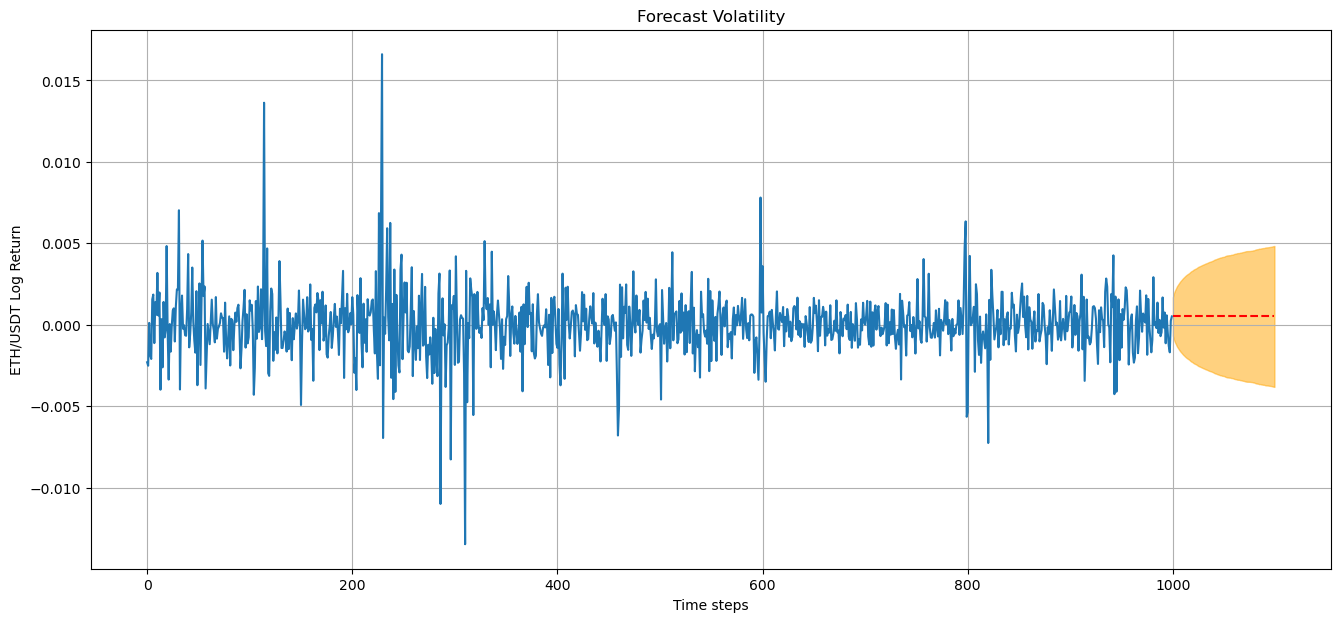

In [16]:
horizon = 100
forecast = model_fit.forecast(reindex=False, horizon=horizon, method="simulation")

variance_fct = pd.DataFrame(data={"Forecast": forecast.variance.values[0]})
variance_fct.index = list(range(len(returns), len(returns) + horizon))
std_fct = [(variance_fct.values[i] * (i + 1)) ** 0.5 for i in range(len(variance_fct))]
volatility_fct = pd.DataFrame(np.sqrt(std_fct))


# upper/lower bands
upper_band = returns.values[-1] * (1.0 + 2 * volatility_fct)
upper_band.index = variance_fct.index
lower_band = returns.values[-1] * (1.0 - 2 * volatility_fct)
lower_band.index = variance_fct.index


plt.figure(figsize=(16, 7))
returns.plot(ylabel="ETH/USDT Log Return", title="Forecast Volatility")
plt.plot((upper_band + lower_band) / 2, "r--")
plt.fill_between(
    upper_band.index.tolist(),
    upper_band.values.T[0],
    lower_band.values.T[0],
    color="orange",
    alpha=0.5,
)
plt.grid()
plt.xlabel('Time steps')
plt.show()

In [2]:
! pip install arch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from arch import arch_model
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import json
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

**1. Processing the data (json -> csv), get only recent returns (last 1000 data points) to make a more accurate forecast**

In [4]:
historical_data = pd.read_csv('C:\\Users\zokt\Desktop\ETH_data.csv')

returns = np.log(historical_data["close"].astype('float')).diff().dropna()

returns = returns [-1000:]
returns.reset_index(drop=True, inplace=True)

returns

0     -0.002307
1     -0.002518
2      0.000109
3     -0.001875
4     -0.002103
         ...   
995   -0.000463
996   -0.001307
997   -0.001696
998    0.000248
999    0.000508
Name: close, Length: 1000, dtype: float64

**2. Returns plot: there are clusters of high volatility**

Text(0, 0.5, 'Return')

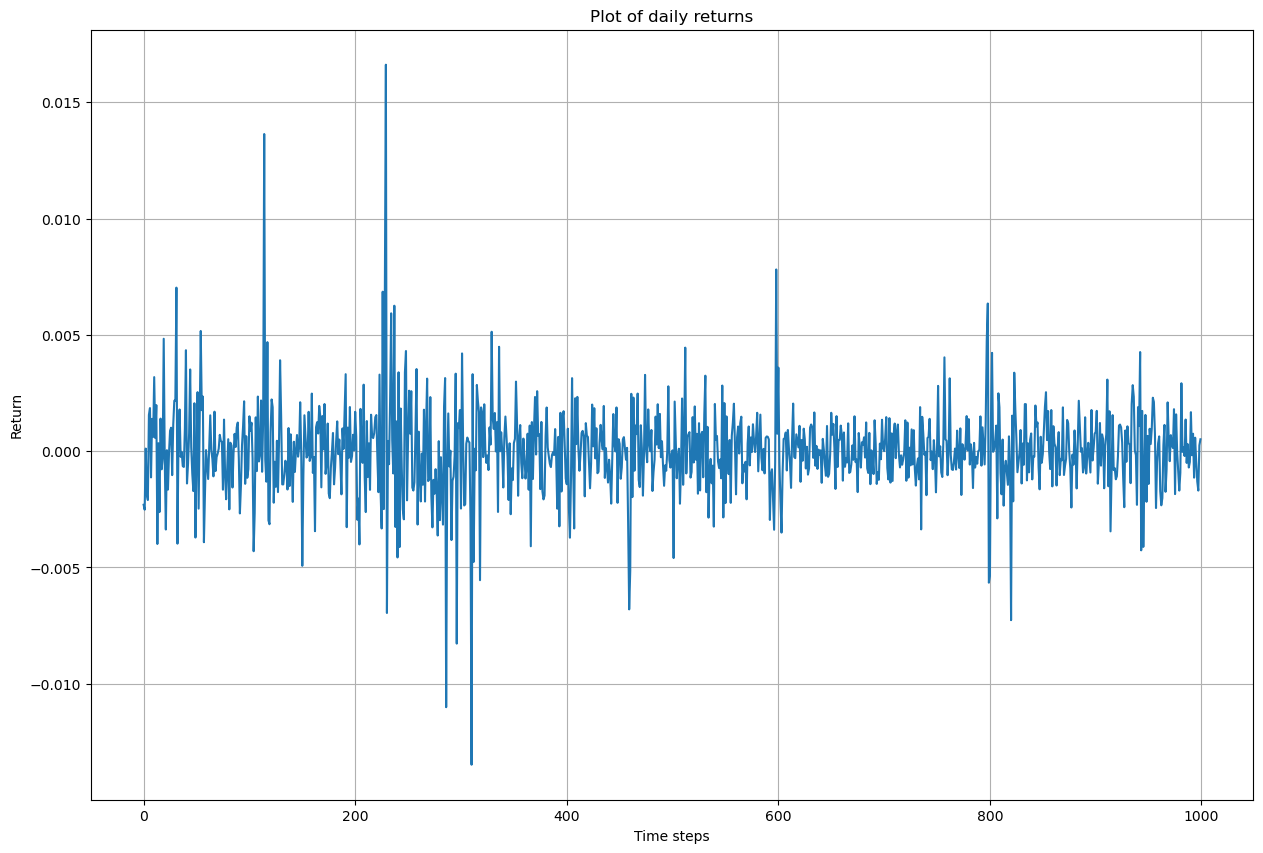

In [7]:
plt.rcParams ["figure.figsize"] = (15,10)
returns.plot()
plt.grid()
plt.title('Plot of daily returns')
plt.xlabel('Time steps')
plt.ylabel('Return')

**3. Partial autocorrelation function (PACF) and Autocorrelation function (ACF) for returns and squared returns**

c:\Users\zokt\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


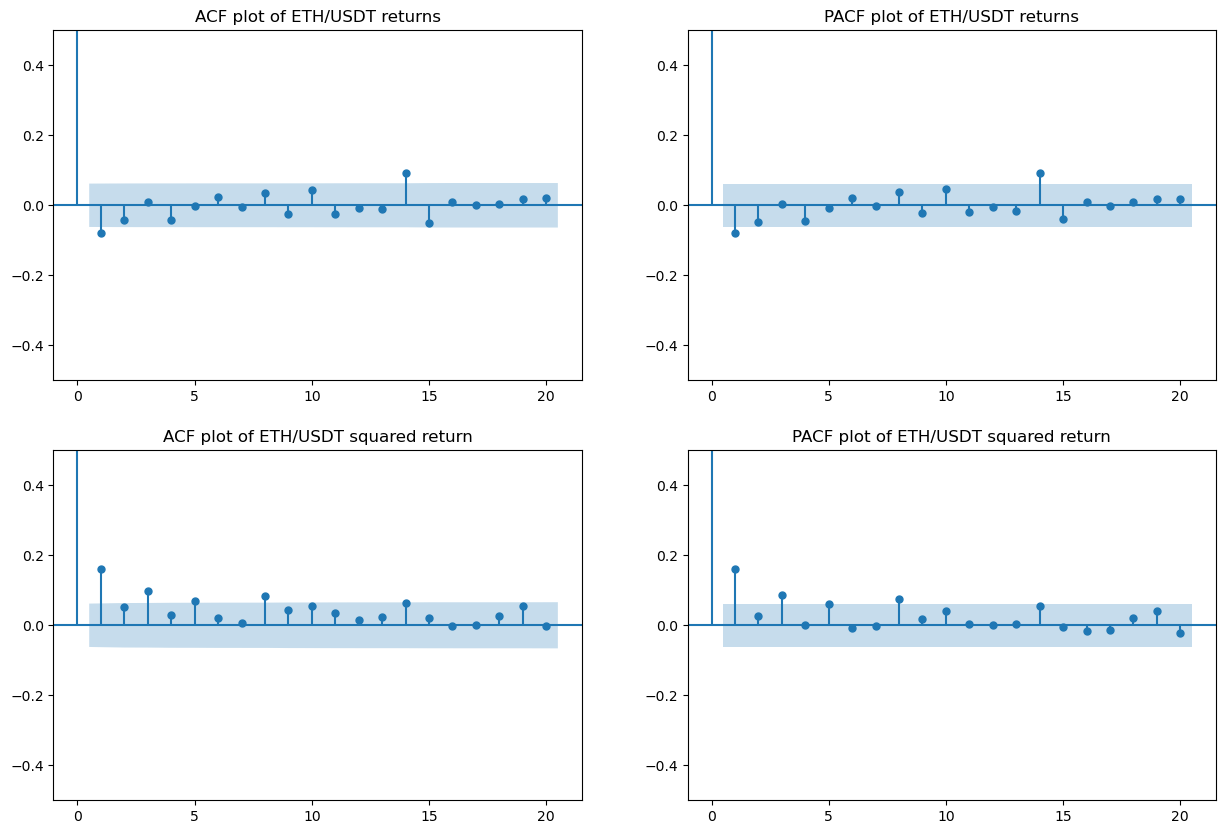

In [8]:
fig, ax = plt.subplots(2, 2)

plot_acf(returns.dropna(), lags=20, ax=ax[0, 0])
ax[0, 0].set(title="ACF plot of ETH/USDT returns")
ax[0, 0].set_ylim([-0.5, 0.5])

plot_pacf(returns.dropna(), lags=20, ax=ax[0, 1])
ax[0, 1].set(title="PACF plot of ETH/USDT returns")
ax[0, 1].set_ylim([-0.5, 0.5])

plot_acf(returns.dropna() ** 2, lags=20, ax=ax[1, 0])
ax[1, 0].set(title="ACF plot of ETH/USDT squared return")
ax[1, 0].set_ylim([-0.5, 0.5])

plot_pacf(returns.dropna() ** 2, lags=20, ax=ax[1, 1])
ax[1, 1].set(title="PACF plot of ETH/USDT squared return")
ax[1, 1].set_ylim([-0.5, 0.5])
plt.show()

**Comment: returns has lags 1 and 14 - significant, squired returns has significant lags 1,3,5,8**

**4. ARCH-LM test for returns**

In [9]:
ARCH_test = het_arch (returns)
# ARCH_test [ARCH_test ['lb_pvalue'] < 0.05]
print ('Lagrange multiplier test statistic: ', ARCH_test[0])
print ('Lagrange multiplier p-value: ', ARCH_test[1])
print ('F statistic for f test: ', ARCH_test[2])
print ('p-value for f test: ', ARCH_test[3])

Lagrange multiplier test statistic:  44.53559474717423
Lagrange multiplier p-value:  2.636943559190362e-06
F statistic for f test:  4.611527098772636
p-value for f test:  1.9639261805392695e-06


**Comment: p-value < 0.05, so I can reject null hypothesis and and conclude there is an ARCH effect in the ARMA model**

**5. Fit a GARCH (1,1) with student's t distributed residuals**

In [11]:
model = arch_model(
    returns,
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist="StudentsT",
    rescale=True,
)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5472.215328953463
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2087.4506646743116
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5829.233790507726
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2082.813561634315
Iteration:      5,   Func. Count:     44,   Neg. LLF: 1906.772577541536
Iteration:      6,   Func. Count:     51,   Neg. LLF: 1906.2537602354935
Iteration:      7,   Func. Count:     57,   Neg. LLF: 1906.216673866723
Iteration:      8,   Func. Count:     63,   Neg. LLF: 1906.212373183738
Iteration:      9,   Func. Count:     69,   Neg. LLF: 1906.2109582362687
Iteration:     10,   Func. Count:     75,   Neg. LLF: 1906.210915594836
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1906.2109124142607
Iteration:     12,   Func. Count:     86,   Neg. LLF: 1906.210912414267
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1906.2109124142607
            Iterations:

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                        close   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1906.21
Distribution:      Standardized Student's t   AIC:                           3822.42
Method:                  Maximum Likelihood   BIC:                           3846.96
                                              No. Observations:                 1000
Date:                      Mon, Dec 19 2022   Df Residuals:                      999
Time:                              09:27:53   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      3.4792e-03  4.344e-02  8.009e-02      0.936 [-8.166e-02,8.862e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1925  9.419e-02      2.043  4.102e-02 [7.848e-03,  0.377]
alpha[1]       0.1080  4.133e-02      2.613  8.972e-03 [2.699e-02,  0.189]
beta[1]        0.8346  5.976e-02     13.966  2.510e-44   [  0.718,  0.952]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.7072      0.694      6.787  1.144e-11 [  3.348,  6.066]
========================================================================

Covariance estimator: robust
"""

**6. Check standardized residuals correlation with Ljung-Box Test**

In [12]:
residuals_correlation = acorr_ljungbox(model_fit.std_resid, return_df=True)
residuals_correlation 

,lb_stat,lb_pvalue
1,0.895168,0.344081
2,1.728768,0.421311
3,1.756188,0.624515
4,4.185937,0.381427
5,4.528115,0.476131
6,4.587813,0.597655
7,4.888985,0.673509
8,4.944044,0.763540
9,5.085500,0.826792
10,6.192808,0.798813


**Comment: standardized residuals doesn't have significant autocorrelations according to Ljung-Box Test**

**7. Test if standardized residuals correspond to Student's t distribution**

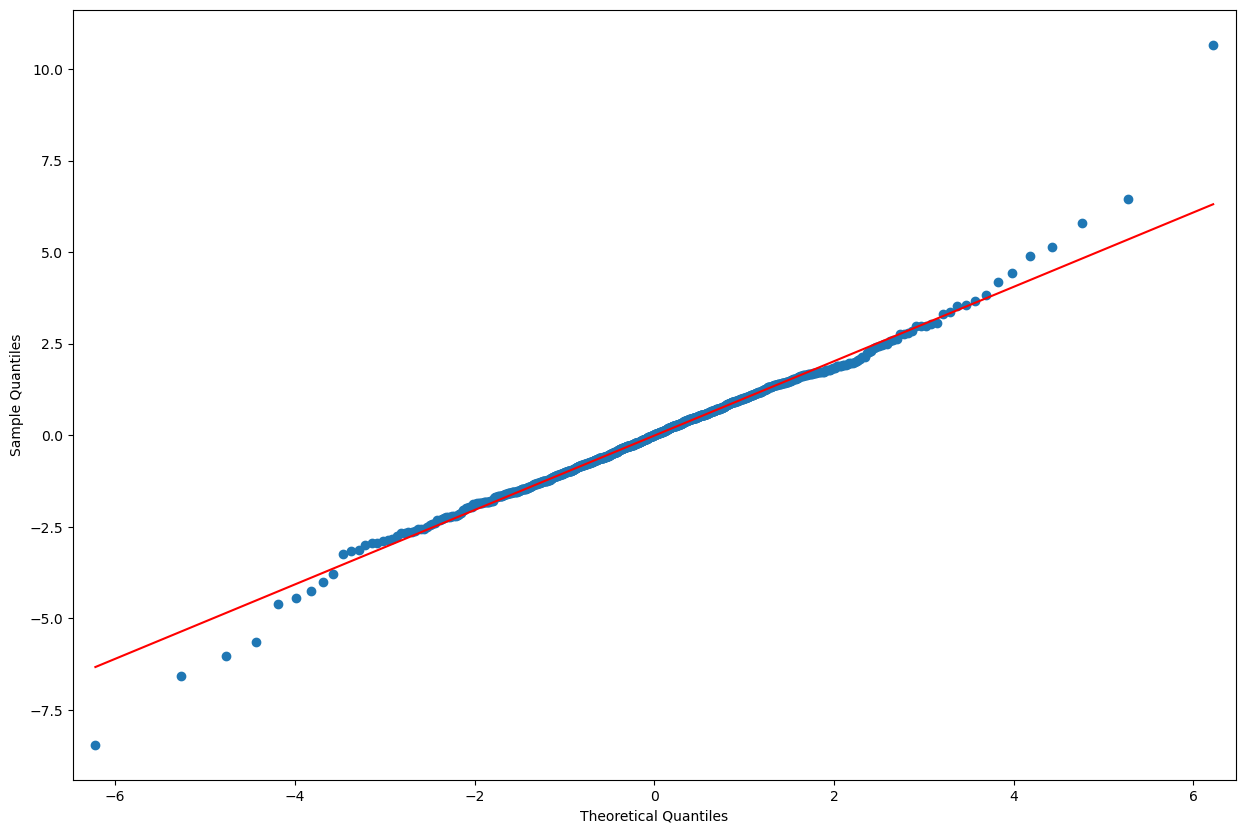

In [13]:
sm.qqplot(model_fit.std_resid, stats.t, fit=True, line="q")
plt.show()

**Comment: Standardized residuals have outliers on Q-Q plot for Student's t distribution**

**8. Histogram standardized residuals and skew test**

SkewtestResult(statistic=2.8317105696117992, pvalue=0.004629973696230718)

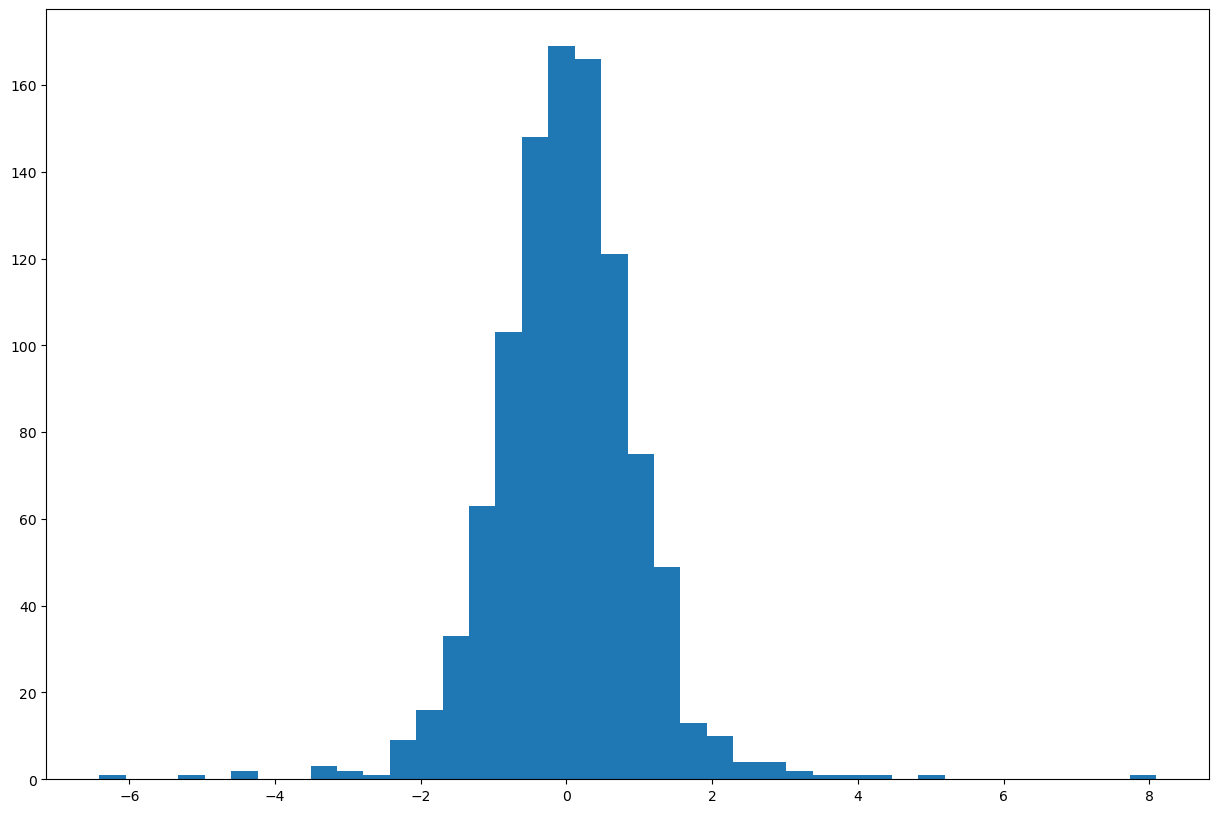

In [14]:
plt.hist(model_fit.std_resid, bins = 40)
stats.skewtest(model_fit.std_resid)

**Comment: Skew test p-value < 0.05 so the skew is same as for normal distribution**